# Imports

In [ ]:
!pip install imbalanced-learn
!pip install xgboost
!pip install lightgbm
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

I stored train.csv and test.csv in disease prediction folder of my google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Colab Notebooks/disease prediction

/content/drive/MyDrive/Colab Notebooks/disease prediction


# Preprocessing

In [ ]:
train = pd.read_csv("train.csv", encoding="latin-1")

First, in order to consolidate the timestamp (day) data of -5, -4, and -3 into a single class, I unified them to -3. Then, I used ffill (forward fill) and bfill (backward fill) for interpolation.

In [ ]:
train = train[train['original'] == 1]
train.loc[train['timestamp(day)'] == -5, 'timestamp(day)'] = -3
train.loc[train['timestamp(day)'] == -4, 'timestamp(day)'] = -3

train = train.fillna(method='ffill')
train = train.fillna(method='bfill')

<ipython-input-20-e4e2d4ac9003>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[train['timestamp(day)'] == -5, 'timestamp(day)'] = -3
<ipython-input-20-e4e2d4ac9003>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[train['timestamp(day)'] == -4, 'timestamp(day)'] = -3


In [ ]:
print(train[train['timestamp(day)'] == -3].shape)
print(train[train['timestamp(day)'] == -2].shape)
print(train[train['timestamp(day)'] == -1].shape)
print(train[train['timestamp(day)'] == 0].shape)

(48326, 37)
(26548, 37)
(37555, 37)
(63085, 37)


As evident from above, the data distributions vary significantly across each class. Therefore, I applied SMOTE (Synthetic Minority Over-sampling Technique) to balance them out. The altered information has been saved separately as "train_smote".

In [ ]:
X = train.drop('timestamp(day)', axis=1)
y = train['timestamp(day)']

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

train_smote = pd.DataFrame(X_resampled, columns=X.columns)
train_smote['timestamp(day)'] = y_resampled

In [ ]:
print(train_smote[train_smote['timestamp(day)'] == -3].shape)
print(train_smote[train_smote['timestamp(day)'] == -2].shape)
print(train_smote[train_smote['timestamp(day)'] == -1].shape)
print(train_smote[train_smote['timestamp(day)'] == 0].shape)

(63085, 37)
(63085, 37)
(63085, 37)
(63085, 37)


The same processing applied to the training set was also performed on the test set.

In [ ]:
test = pd.read_csv("test.csv", encoding="latin-1")

In [ ]:
test = test[test['original'] == 1]
test.loc[test['timestamp(day)'] == -5, 'timestamp(day)'] = -3
test.loc[test['timestamp(day)'] == -4, 'timestamp(day)'] = -3

test = test.fillna(method='ffill')
test = test.fillna(method='bfill')

<ipython-input-26-706281b969d7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[test['timestamp(day)'] == -5, 'timestamp(day)'] = -3
<ipython-input-26-706281b969d7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[test['timestamp(day)'] == -4, 'timestamp(day)'] = -3


# EDA


Below is the number of patients in train dataset.

In [ ]:
len(train[(train['timestamp(day)'] == 0) & (train['timestamp(hr)'] == 0)])

4156

Below shows mean value and median value of train dataset.

In [ ]:
print(train['timestamp(day)'].mean())
print(train['timestamp(day)'].median())

-1.3425082899369851
-1.0


To perform EDA (Exploratory Data Analysis), the class data and metadata were removed, and the resulting dataset was saved separately as "train_eda."

In [ ]:
train_eda = train.drop(['timestamp(day)', 'timestamp(hr)', 'original'], axis=1)

The blue bars in the graph represent the mean, while the line represents the standard deviation.

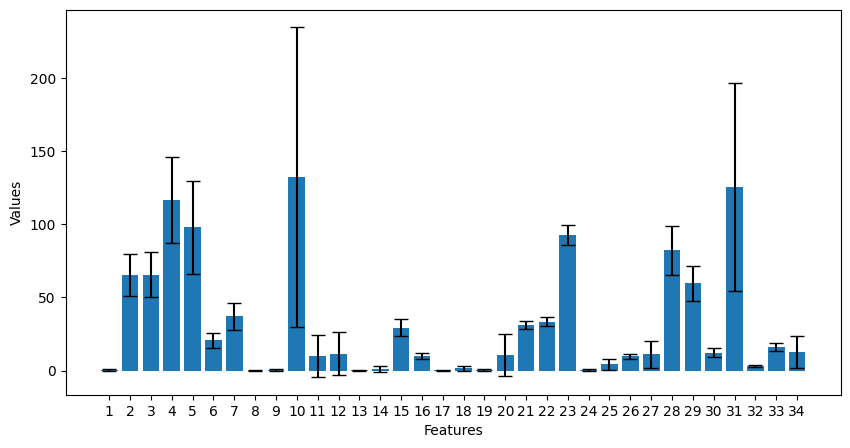

In [ ]:
means = train_eda.mean()
stds = train_eda.std()

plt.figure(figsize=(10, 5))
plt.bar(means.index, means, yerr=stds, capsize=5)
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

Below is a graph depicting the correlation between features 1 to 34.

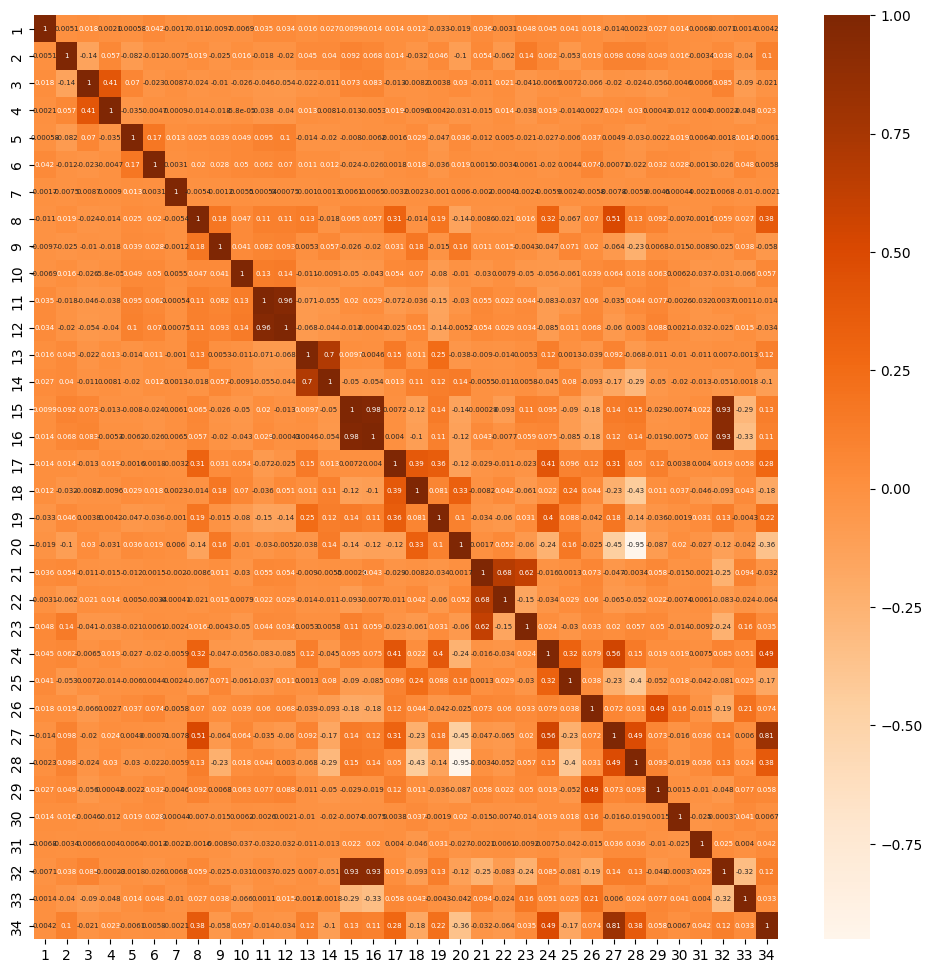

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(train_eda.corr(), annot = True, cmap='Oranges', annot_kws={'size': 5}) 
plt.show()

From the graph above, we can observe that features 11 and 12 exhibit a high correlation of 0.96. Similarly, features 15, 16, and 32 show a correlation of above 0.9 with each other. Additionally, features 27 and 34 also demonstrate a significant correlation of 0.81.

Therefore, I removed the features with strong correlations, namely, 11, 15, 16, and 27.

In [ ]:
train = train.drop(['11', '15', '16', '27'], axis=1)
train_smote = train_smote.drop(['11', '15', '16', '27'], axis=1)
test = test.drop(['11', '15', '16', '27'], axis=1)

# Model Selection



# Model Tuning



# Model Evaluation / Metrics